# **8. Char Generator**

- This is adopted from [Makemore, Andrej Karpathy](https://github.com/karpathy/makemore)
- Karpathy refers to [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) (**Note:** please read this paper first)

What are we going to do?
- We will create the char generator to **generate Indonesian names**.
- The dataset we're using is scrapped from public website.

# **$1^{\text{st}}$ Try - Understand the Modeling Pipeline (from the paper)**
---

In [1]:
# Import library
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1.1 Read the data
---

- First, we can read all the name from file `indonesian_name.txt`

In [2]:
WORDS_PATH = '../data/indonesian_name.txt'

In [3]:
# Get all the words
words = (
    open(WORDS_PATH, 'r')
    .read()
    .splitlines()
)

print(f'Number of words      :', len(words))
print(f'Maximum chars in word:', max([len(w) for w in words]))
print(words[:10])

Number of words      : 7872
Maximum chars in word: 17
['aaron', 'ababiel', 'abadi', 'aban', 'abbil', 'abbiyu', 'abd', 'abdalla', 'abdallah', 'abdi']


- Now get the characters

In [4]:
# Get all the characters
chars = sorted(list(set(''.join(words))))

print(f'Number of chars:', len(chars))
print(''.join(chars))

Number of chars: 26
abcdefghijklmnopqrstuvwxyz


- Next, create mappers
  - index to char
  - char to index

In [5]:
# Create char to index
ctoi = {char:idx+1 for idx, char in enumerate(chars)}
ctoi['.'] = 0       # For defining stop condition

# Create index to char
itoc = {idx:char for char, idx in ctoi.items()}

# Get the vocab size, i.e. the char size in ctoi or itoc
vocab_size = len(itoc)

print(f'Vocab size: {vocab_size}')
print(f'Index to char')
print(itoc)

Vocab size: 27
Index to char
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## 1.2 Build dataset
---

- We're going to predict the next word, e.g.
- Using number of context = 8

```
for 'budi'
input, target
........ -> b
.......b -> u
......bu -> d
.....bud -> i
....budi -> .
```

```
for 'gumelar'
input, target
........ -> g
.......g -> u
......gu -> m
.....gum -> e
....gume -> l
...gumel -> a
..gumela -> r
.gumelar -> .
```

In [6]:
# Define block size
BLOCK_SIZE = 8

In [7]:
def build_dataset(words):
    X, y = [], []

    # Iterate over words
    for word in words:
        # Generate the context (input)
        # i.e. [0, 0, 0, 0, 0, 0, 0, 0] --> we will fill the context with chars index
        context = [0] * BLOCK_SIZE

        # Fill the context fo every word + '.', e.g. 'budi.'
        for char in word + '.':
            # Get char index
            ix = ctoi[char]

            # Append context to X and target to y
            X.append(context)
            y.append(ix)

            # Roll the context
            context = context[1:] + [ix]

    # Convert to tensor
    X = torch.tensor(X)
    y = torch.tensor(y)

    # Validate
    print('X shape:', X.shape)
    print('y shape:', y.shape)

    return X, y


In [8]:
X, y = build_dataset(words)

X shape: torch.Size([60887, 8])
y shape: torch.Size([60887])


In [9]:
# Print dataset sample
print('context ', '-->', 'target')
print(20*'=')
for context_idx, target_idx in zip(X[:25], y[:25]):
    context_char = ''.join([itoc[idx.item()] for idx in context_idx])
    target_char = itoc[target_idx.item()]

    print(context_char, '-->', target_char)

context  --> target
........ --> a
.......a --> a
......aa --> r
.....aar --> o
....aaro --> n
...aaron --> .
........ --> a
.......a --> b
......ab --> a
.....aba --> b
....abab --> i
...ababi --> e
..ababie --> l
.ababiel --> .
........ --> a
.......a --> b
......ab --> a
.....aba --> d
....abad --> i
...abadi --> .
........ --> a
.......a --> b
......ab --> a
.....aba --> n
....aban --> .


- Now, let's split the data
- 80% train, 10% valid, 10% test

In [10]:
import random

In [11]:
random.seed(42)

# Shuffle the word first
random.shuffle(words)

# Get the split size
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# Split the dataset
X_train, y_train = build_dataset(words[:n1])
X_valid, y_valid = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

X shape: torch.Size([48740, 8])
y shape: torch.Size([48740])
X shape: torch.Size([6128, 8])
y shape: torch.Size([6128])
X shape: torch.Size([6019, 8])
y shape: torch.Size([6019])


## 1.3 Modeling
---

- From Bengio et. al (2023), we want to create this kind of architectures

![](../assets/mlp_arch_bengio.png)

- So, our architecture should be consist of two building blocks, i.e.
  1. The character vectorizer --> embedding
  2. The multiclass classifier --> could be anything, e.g. logistic regression, MLP, RNN, etc.

### **1. Character Embedding**

---

- The embedding convert a character to a vector, e.g. embedding of our character vocabulary to vector with 10 dimensions

```
illustration
'.' --> [0.3, 0.2, 0.1, 0.3, 0.5, -0.1, 0.9, -2.2, 1.0]
'a' --> [0.4, 0.1, 0.5, 1.3, 6.5, -2.1, -0.9, -2.1, 5.0]
...
```

- Let's create the embedding vector `C`

In [12]:
g = torch.Generator().manual_seed(42)

In [13]:
# Define embedding dimension
n_embd = 3

# Create embedding vector
C = torch.randn((vocab_size, n_embd), generator=g)
C[:5]

tensor([[ 1.9269,  1.4873,  0.9007],
        [-2.1055,  0.6784, -1.2345],
        [-0.0431, -1.6047, -0.7521],
        [ 1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688]])

- So the vector of char `'.'` is `[ 1.9269,  1.4873,  0.9007]`

- Before inserting to the classifier, we need to flatten all the embedding vector.

<img src="../assets/mlp_arch_bengio_detail.png">

- Say we want to flatten 2 datas

In [14]:
X_samples = X_train[:2]
print(X_samples.shape)
X_samples

torch.Size([2, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 13]])

- We will have

```
Context index:
[0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23]
 <--       first data       -->  <--       second data     -->
```

- That turn to

```python
emb = [
    # 1st data
    [
        [1.9269, 1.4873, 0.9007],  # 1st char in 1st data context ('.')
        [1.9269, 1.4873, 0.9007],  # 2nd char in 1st data context ('.')
        ...,
        [1.9269, 1.4873, 0.9007]   # last char in 1st data context ('.')
    ],

    # 2nd data
    [
        [1.9269, 1.4873, 0.9007],  # 1st char in 2nd data context ('.')
        [1.9269, 1.4873, 0.9007],  # 2nd char in 2nd data context ('.')
        ...,
        [0.5246, 1.1412, 0.0516]   # last char in 2nd data context ('a')
    ]
]
```

- Looks easy right?

In [15]:
# Get the unflattened embedding
emb = C[X_samples]
print(emb.shape)
emb

torch.Size([2, 8, 3])


tensor([[[ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007]],

        [[ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [ 1.9269,  1.4873,  0.9007],
         [-0.7746, -1.5576,  0.9956]]])

In [16]:
# Flatten the embedding
# The shape should be (2, 8x3) -> (2, 24) --> 8 for number of context and 3 for embedding size
emb_flatten = emb.view(X_samples.shape[0], -1)
print(emb_flatten.shape)
emb_flatten

torch.Size([2, 24])


tensor([[ 1.9269,  1.4873,  0.9007,  1.9269,  1.4873,  0.9007,  1.9269,  1.4873,
          0.9007,  1.9269,  1.4873,  0.9007,  1.9269,  1.4873,  0.9007,  1.9269,
          1.4873,  0.9007,  1.9269,  1.4873,  0.9007,  1.9269,  1.4873,  0.9007],
        [ 1.9269,  1.4873,  0.9007,  1.9269,  1.4873,  0.9007,  1.9269,  1.4873,
          0.9007,  1.9269,  1.4873,  0.9007,  1.9269,  1.4873,  0.9007,  1.9269,
          1.4873,  0.9007,  1.9269,  1.4873,  0.9007, -0.7746, -1.5576,  0.9956]])

### **2. Our model**

---

- Now we define the model, i.e. an MLP with 1 hidden layer & 1 output layer
- The hidden layer needs `block_size*n_embd` input size and `n_hidden` output size
- The output layer needs `n_hidden` input size and `vocab_size` output size

In [17]:
# Define n_hidden
n_hidden = 100

# Define the model parameters
# For hidden layer
W1 = torch.randn((BLOCK_SIZE*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)

# For output layer
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

- Let's forward pass the information

In [18]:
# In hidden layer
# Find the pre-activated value
h_pre_act = emb_flatten @ W1 + b1
print(h_pre_act.shape)
h_pre_act

torch.Size([2, 100])


tensor([[  5.2682,   6.3252,   7.1898,  -2.5402,   8.5029,  17.4430,   5.5025,
           0.9174,   6.2955,  10.1558,   4.2166,   3.3713,   4.5578, -12.1551,
          -3.9118,  -2.7044,  -6.7685,   0.9250,  -5.3482,   2.0212,   1.7470,
          -1.8980,   6.9548,   5.7182, -12.8488,  12.1636,   4.9464,   2.6657,
           6.8974,  -8.7187,   7.0057,  -4.7390,   4.7148, -11.4654,   4.5402,
           9.4069,  -5.5390, -10.3612,  15.4873,  -6.0531,  -6.6360,   4.5821,
          10.3351,   5.6579,   1.3586,  10.7093, -14.9284, -11.7898,  14.8563,
          -5.9924,   7.7442,  -1.9801,   8.5644,   0.4041,   9.3385,   3.4834,
          -0.2290,  -7.6089,   6.4224,   4.2266,  -3.4875, -16.7647,   7.8674,
           5.4883,  14.5354, -10.5081,  17.4915,   4.1982,  -7.4184,   4.0560,
          -4.1485,   7.8443, -11.7026, -12.4274, -20.9969,  -7.0935,  -8.6705,
           7.5531,   5.2412,  -9.1616, -10.2890,   2.1480,  -5.5404,  -6.1336,
           5.1891,  -5.4701,  -3.8719,   3.7288,   1

In [19]:
# Then, activate it with tanH activation function
h = torch.tanh(h_pre_act)
print(h.shape)
h

torch.Size([2, 100])


tensor([[ 0.9999,  1.0000,  1.0000, -0.9876,  1.0000,  1.0000,  1.0000,  0.7246,
          1.0000,  1.0000,  0.9996,  0.9976,  0.9998, -1.0000, -0.9992, -0.9911,
         -1.0000,  0.7282, -1.0000,  0.9655,  0.9410, -0.9561,  1.0000,  1.0000,
         -1.0000,  1.0000,  0.9999,  0.9904,  1.0000, -1.0000,  1.0000, -0.9998,
          0.9998, -1.0000,  0.9998,  1.0000, -1.0000, -1.0000,  1.0000, -1.0000,
         -1.0000,  0.9998,  1.0000,  1.0000,  0.8761,  1.0000, -1.0000, -1.0000,
          1.0000, -1.0000,  1.0000, -0.9626,  1.0000,  0.3835,  1.0000,  0.9981,
         -0.2251, -1.0000,  1.0000,  0.9996, -0.9981, -1.0000,  1.0000,  1.0000,
          1.0000, -1.0000,  1.0000,  0.9995, -1.0000,  0.9994, -0.9995,  1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  1.0000,  0.9999, -1.0000,
         -1.0000,  0.9731, -1.0000, -1.0000,  0.9999, -1.0000, -0.9991,  0.9988,
          0.9300,  0.9998, -1.0000,  1.0000, -1.0000,  1.0000,  1.0000, -1.0000,
          0.9990,  0.8440,  

In [20]:
# After that we find the logits from the output layer
logits = h @ W2 + b2
print(logits.shape)
logits

torch.Size([2, 27])


tensor([[  5.5174,   1.3106,   7.7886, -12.2630,  -0.3254,   6.7035,  20.2166,
           5.6740, -10.8276, -10.1822, -11.6496,  11.5447,   7.8219,   0.5122,
          -8.4570,   9.3249,  -9.5133,   4.3423,  11.5071,  -7.1407,  -6.4799,
          11.4697,  -2.4887,  16.4487,   2.9806,  -9.7058,   3.9017],
        [  2.5201,   8.3830,  -3.5453,  -4.9275,   3.4754,   6.0622,  13.2329,
           7.2177, -17.3718,  -8.9218,  -8.1375,   2.1004,   6.2601,  -4.1042,
         -11.1653,  10.1393,  -7.8310,   4.8580,  10.5171, -11.0650,  -8.0657,
          10.5573,  -5.7966,  10.2257,   1.9335,  -3.0331,   5.9620]])

### **3. Perform training**

---

- Re initialize all

In [21]:
# Initialize
n_embd = 50  # let's enlarge the embedding size, so a char is represented by 50 sized vector
n_hidden = 100

# Define the model parameter
g = torch.Generator().manual_seed(42)  # Define the random number generator
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((BLOCK_SIZE*n_embd, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # we scale the weights to reduce initial loss
b2 = torch.randn(vocab_size, generator=g) * 0.0               # we scale the biases to reduce initial loss

# Summarize the parameters
parameters = [C, W1, b1, W2, b2]
print('Total number of parameters :', sum([p.nelement() for p in parameters]))

# Activate grad
for p in parameters:
    p.requires_grad = True

Total number of parameters : 44177


- Start the iteration

In [22]:
import time

In [23]:
# Initialize
batch_size = 32
max_iter = 200_000
losses = []

# Iterate
for iter in range(max_iter):
    t1 = time.time()

    # Construct the minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch = X_train[ix]
    y_batch = y_train[ix]

    # Forward pass
    emb = C[X_batch]
    emb_flatten = emb.view(X_batch.shape[0], -1)
    h_pre_act = emb_flatten @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if iter < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Append the loss
    losses.append(loss.item())
    elapsed = time.time() - t1
    if iter % 5000 == 0:
        print(f"Step {iter:7d}/{max_iter:7d} "
              f"| Loss {loss.item():.4f} "
              f"| Step time {elapsed*1000:.2f} ms")


Step       0/ 200000 | Loss 3.3229 | Step time 4.01 ms


Step    5000/ 200000 | Loss 2.5434 | Step time 0.71 ms
Step   10000/ 200000 | Loss 2.2059 | Step time 0.91 ms
Step   15000/ 200000 | Loss 2.1022 | Step time 0.93 ms
Step   20000/ 200000 | Loss 2.1243 | Step time 0.94 ms
Step   25000/ 200000 | Loss 2.0396 | Step time 0.70 ms
Step   30000/ 200000 | Loss 2.5270 | Step time 0.70 ms
Step   35000/ 200000 | Loss 2.1818 | Step time 0.71 ms
Step   40000/ 200000 | Loss 2.1506 | Step time 0.71 ms
Step   45000/ 200000 | Loss 2.2582 | Step time 0.71 ms
Step   50000/ 200000 | Loss 2.4017 | Step time 0.70 ms
Step   55000/ 200000 | Loss 1.9348 | Step time 0.93 ms
Step   60000/ 200000 | Loss 2.4389 | Step time 0.69 ms
Step   65000/ 200000 | Loss 1.9433 | Step time 0.69 ms
Step   70000/ 200000 | Loss 2.2317 | Step time 0.71 ms
Step   75000/ 200000 | Loss 1.9814 | Step time 0.68 ms
Step   80000/ 200000 | Loss 2.0045 | Step time 0.70 ms
Step   85000/ 200000 | Loss 2.0239 | Step time 0.71 ms
Step   90000/ 200000 | Loss 2.3753 | Step time 0.69 ms
Step   950

- Let's plot the loss

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

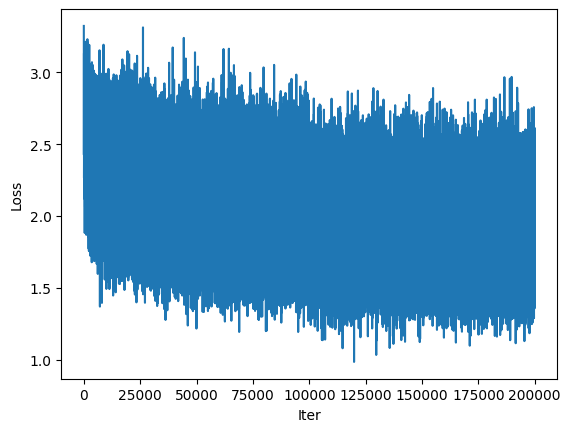

In [25]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('Iter'); plt.ylabel('Loss')
plt.show()

- Now let's evaluate

In [26]:
@torch.no_grad()
def evaluate_loss(type):
    # Get the data
    X, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[type]

    # Do the forward pass
    emb = C[X]
    emb_flatten = emb.view(X.shape[0], -1)
    h_pre_act = emb_flatten @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    print(f'Loss on {type} data:', loss.item())

In [27]:
# Evaluate on train & valid
evaluate_loss('train')
evaluate_loss('valid')

Loss on train data: 1.9094129800796509
Loss on valid data: 2.342254638671875


- Not so good, but we have created the pipeline
- Let's generate the results

In [28]:
g_ = torch.Generator().manual_seed(1234)

In [29]:
# Sample from model
n_samples = 20
with torch.no_grad():
    for _ in range(n_samples):
        # Define output generated index
        out = []

        # Define context
        context = [0] * BLOCK_SIZE

        # Iterate while char is not '.'
        while True:
            # Forward pass
            emb = C[torch.tensor([context])]
            emb_flatten = emb.view(1, -1)
            h_pre_act = emb_flatten @ W1 + b1
            h = torch.tanh(h_pre_act)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)  # Get the probability of generating new chars

            # Now, let's sample the new char from the given probability
            ix = torch.multinomial(probs, num_samples=1, generator=g_).item()

            # Update the context
            context = context[1:] + [ix]

            # append to out list
            out.append(ix)

            # Stopping the iteration
            if ix == 0:
                break

        # After getting all the new char, we decode index to char
        print(''.join([itoc[ix] for ix in out]))

kendika.
daniani.
bivadqa.
yasi.
zyin.
freundido.
shofa.
bouma.
caruswarika.
yurdoniva.
rahmada.
ningohi.
sousykhinra.
mahara.
nya.
faktis.
lataery.
diagia.
vaira.
jendo.


# **$2^{\text{nd}}$ Try - Build a Better DL Model and Supervised the Learning Process**
---

## 2.1 Build a Simple MLP Class object

---

- MLP with 1 hidden layer & 1 output layer

In [30]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Extract parameters
        # We extract several network information
        block_size = config['block_size']
        vocab_size = config['vocab_size']
        n_embd = config['n_embd']
        n_hidden = config['n_hidden']

        # Create the layer
        torch.manual_seed(42)

        # The char embedding
        self.C = nn.Embedding(vocab_size, n_embd)

        # The MLP
        self.mlp = nn.Sequential(
            # The hidden layer
            nn.Linear(block_size*n_embd, n_hidden),
            nn.Tanh(),

            # The output layer
            nn.Linear(n_hidden, vocab_size),
        )

    def forward(self, idx):
        # Create the embedding
        embs = self.C(idx)

        # Forward pass
        # Flatten the image first
        embs_flatten = embs.view(embs.shape[0], -1)

        # Then find the logits
        logits = self.mlp(embs_flatten)

        return logits


- Define the model configuration

In [31]:
config = {
    'vocab_size': vocab_size,
    'block_size': BLOCK_SIZE,
    'n_hidden': 100,
    'n_embd': 50
}

- Create the model

In [32]:
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

#parameters : 44177


## 2.2 Sanity Check the First Iteration Loss
---

- Now, let's sanity check the first iteration loss.
- It should be `-log(1/vocab_size)`

In [33]:
# Create a training function
def train(model,
          batch_size,
          X_train,
          y_train,
          max_iter,
          lr,
          generator):
    # Initialize
    losses = []

    # Iterate
    for iter in range(max_iter):
        t1 = time.time()

        # Construct the minibatch
        if batch_size is not None:
            ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
            X_batch = X_train[ix]
            y_batch = y_train[ix]
        else:
            X_batch = X_train
            y_batch = y_train

        # Forward pass
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)

        # Backward pass
        model.zero_grad(set_to_none=True)
        loss.backward()

        # Update the parameters
        learning_rate = lr if iter < 100_000 else lr/10.
        for p in model.parameters():
            p.data += -learning_rate * p.grad

        # Append the loss
        losses.append(loss.item())
        elapsed = time.time() - t1
        if max_iter == 1:
            print(f"Step {iter:7d}/{max_iter:7d} "
                f"| Loss {loss.item():.4f} "
                f"| Step time {elapsed*1000:.2f} ms")

        elif iter % int(max_iter/40) == 0:
            print(f"Step {iter:7d}/{max_iter:7d} "
                f"| Loss {loss.item():.4f} "
                f"| Step time {elapsed*1000:.2f} ms")

    return losses


In [34]:
# Check the first loss
losses = train(
    model=mlp_v1,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=1,
    lr=0.1,
    generator=g
)

Step       0/      1 | Loss 3.3392 | Step time 1.96 ms


In [35]:
# Expected initial loss
-torch.tensor([1/vocab_size]).log()

tensor([3.2958])

- Nice! It's close enough

## 2.3 Overfit a Small Portion of the Training Data

---

- Assume our model will go well, then our model could overfit a small portion of the training data

In [36]:
# Construct a minibatch
ix = torch.randint(0, X_train.shape[0], (10,), generator=g)
X_batch = X_train[ix]
y_batch = y_train[ix]

In [37]:
# Build the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

# Check wether our model can overfit a small batch
losses = train(
    model=mlp_v1,
    batch_size=None,
    X_train=X_batch,
    y_train=y_batch,
    max_iter=200,
    lr=0.1,
    generator=g
)

#parameters : 44177
Step       0/    200 | Loss 3.4060 | Step time 9.19 ms


Step       5/    200 | Loss 0.9321 | Step time 0.96 ms
Step      10/    200 | Loss 0.3830 | Step time 1.00 ms
Step      15/    200 | Loss 0.1990 | Step time 0.96 ms
Step      20/    200 | Loss 0.1256 | Step time 2.17 ms
Step      25/    200 | Loss 0.0893 | Step time 0.95 ms
Step      30/    200 | Loss 0.0684 | Step time 1.00 ms
Step      35/    200 | Loss 0.0550 | Step time 0.99 ms
Step      40/    200 | Loss 0.0458 | Step time 0.97 ms
Step      45/    200 | Loss 0.0391 | Step time 0.97 ms
Step      50/    200 | Loss 0.0341 | Step time 0.98 ms
Step      55/    200 | Loss 0.0301 | Step time 0.96 ms
Step      60/    200 | Loss 0.0270 | Step time 0.99 ms
Step      65/    200 | Loss 0.0244 | Step time 0.97 ms
Step      70/    200 | Loss 0.0222 | Step time 0.97 ms
Step      75/    200 | Loss 0.0204 | Step time 1.80 ms
Step      80/    200 | Loss 0.0189 | Step time 1.00 ms
Step      85/    200 | Loss 0.0175 | Step time 0.95 ms
Step      90/    200 | Loss 0.0164 | Step time 0.97 ms
Step      

- Great! Loss = 0.0067 is small enough
- Your model can overfit this data
- Let's evaluate

In [38]:
@torch.no_grad()
def evaluate_loss(model, type):
    # Get the data
    X, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[type]

    # Do the forward pass
    logits = model(X)
    loss = F.cross_entropy(logits, y)

    print(f'Loss on {type} data:', loss.item())

In [39]:
# Evaluate on train & valid
evaluate_loss(mlp_v1, 'train')
evaluate_loss(mlp_v1, 'valid')

Loss on train data: 4.381712436676025
Loss on valid data: 4.376656532287598


## 2.4 Find the learning rates

---

- Our deep learning model is sensitive to learning rate.
- We need to find the correct learning rate.
- Let's start by finding the learning rate boundary from few iterations

- Find learning rates
- do with small iteration

In [40]:
# Build the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

# Check wether our model can overfit a small batch
losses = train(
    model=mlp_v1,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200,
    lr=1.e-6,
    generator=g
)

#parameters : 44177
Step       0/    200 | Loss 3.4452 | Step time 1.16 ms
Step       5/    200 | Loss 3.3251 | Step time 3.26 ms
Step      10/    200 | Loss 3.3317 | Step time 0.87 ms
Step      15/    200 | Loss 3.3858 | Step time 0.84 ms
Step      20/    200 | Loss 3.3982 | Step time 0.87 ms
Step      25/    200 | Loss 3.3889 | Step time 0.86 ms
Step      30/    200 | Loss 3.3648 | Step time 0.85 ms
Step      35/    200 | Loss 3.3174 | Step time 0.86 ms
Step      40/    200 | Loss 3.2996 | Step time 0.90 ms
Step      45/    200 | Loss 3.4362 | Step time 0.87 ms
Step      50/    200 | Loss 3.3903 | Step time 0.88 ms
Step      55/    200 | Loss 3.3704 | Step time 0.86 ms
Step      60/    200 | Loss 3.2682 | Step time 0.85 ms
Step      65/    200 | Loss 3.2668 | Step time 0.89 ms
Step      70/    200 | Loss 3.4467 | Step time 0.87 ms
Step      75/    200 | Loss 3.4612 | Step time 0.90 ms
Step      80/    200 | Loss 3.3669 | Step time 0.88 ms
Step      85/    200 | Loss 3.3570 | Step tim

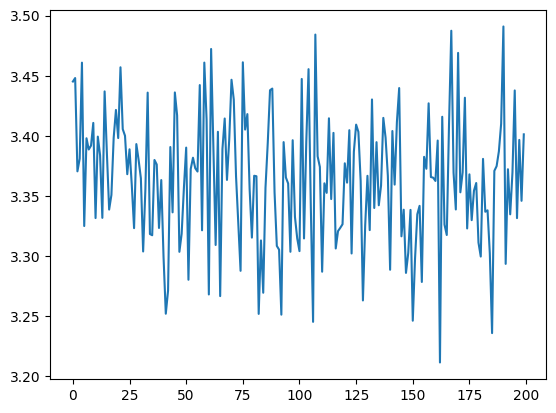

In [41]:
plt.plot(losses)

- You see that the loss is barely changing
- We can set `1e-6` as our lower learning rate boundary
- Now let's find the upper learning rate boundary

In [42]:
# Build the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

# Check wether our model can overfit a small batch
losses = train(
    model=mlp_v1,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200,
    lr=1.e6,
    generator=g
)

#parameters : 44177
Step       0/    200 | Loss 3.3132 | Step time 1.30 ms
Step       5/    200 | Loss 27203472.0000 | Step time 0.89 ms
Step      10/    200 | Loss 37747624.0000 | Step time 0.85 ms
Step      15/    200 | Loss 30264934.0000 | Step time 0.84 ms
Step      20/    200 | Loss 12696472.0000 | Step time 0.84 ms
Step      25/    200 | Loss 29651334.0000 | Step time 0.85 ms
Step      30/    200 | Loss 19898496.0000 | Step time 0.86 ms
Step      35/    200 | Loss 19286934.0000 | Step time 0.89 ms
Step      40/    200 | Loss 33109740.0000 | Step time 0.84 ms
Step      45/    200 | Loss 22293742.0000 | Step time 0.84 ms
Step      50/    200 | Loss 21214950.0000 | Step time 0.84 ms
Step      55/    200 | Loss 27501310.0000 | Step time 0.84 ms
Step      60/    200 | Loss 32985126.0000 | Step time 0.87 ms
Step      65/    200 | Loss 31003074.0000 | Step time 0.87 ms
Step      70/    200 | Loss 25657868.0000 | Step time 0.87 ms
Step      75/    200 | Loss 24275564.0000 | Step time 0.8

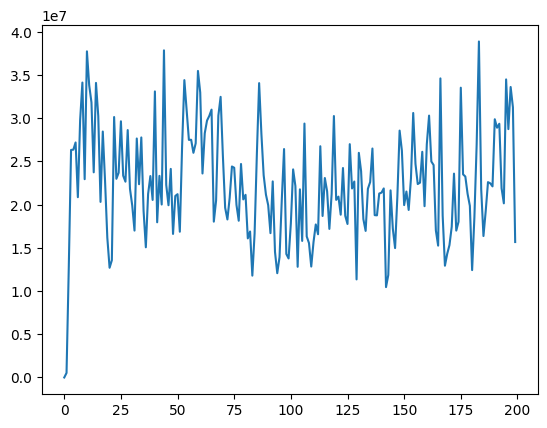

In [43]:
plt.plot(losses)

- The loss is not going down --> learning rate is too high
- Let's reduce the learning rate

In [44]:
# Build the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

# Check wether our model can overfit a small batch
losses = train(
    model=mlp_v1,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200,
    lr=3.e-3,
    generator=g
)

#parameters : 44177
Step       0/    200 | Loss 3.3121 | Step time 1.21 ms
Step       5/    200 | Loss 3.3307 | Step time 0.84 ms
Step      10/    200 | Loss 3.2973 | Step time 1.24 ms
Step      15/    200 | Loss 3.2417 | Step time 0.84 ms
Step      20/    200 | Loss 3.2964 | Step time 1.00 ms
Step      25/    200 | Loss 3.2446 | Step time 0.88 ms
Step      30/    200 | Loss 3.1813 | Step time 0.84 ms
Step      35/    200 | Loss 3.2471 | Step time 0.84 ms
Step      40/    200 | Loss 3.1912 | Step time 0.88 ms
Step      45/    200 | Loss 3.1128 | Step time 0.86 ms
Step      50/    200 | Loss 3.0333 | Step time 0.85 ms
Step      55/    200 | Loss 3.1743 | Step time 0.84 ms
Step      60/    200 | Loss 3.1116 | Step time 0.84 ms
Step      65/    200 | Loss 3.1532 | Step time 0.84 ms
Step      70/    200 | Loss 3.0363 | Step time 0.84 ms
Step      75/    200 | Loss 3.0423 | Step time 0.87 ms
Step      80/    200 | Loss 2.9082 | Step time 0.87 ms
Step      85/    200 | Loss 3.1135 | Step tim

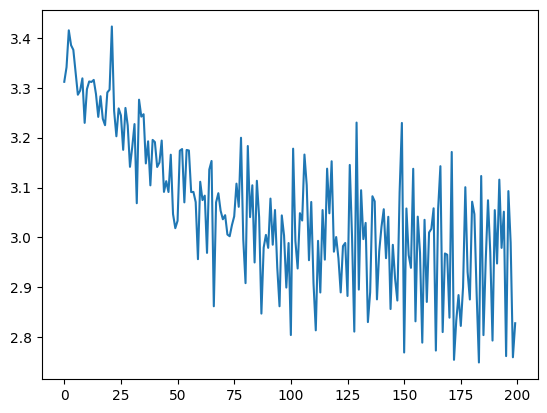

In [45]:
plt.plot(losses)

- We see that the loss is decreasing, but at higher iteration, it tends to level out.
- We can then cross validate the learning rate in range of `[1e-3 ... 1e-6]`

## 2.5 Cross Validation

---

Our strategy
1. Coarse search = use few epoch to get the rough ideas about how params work
2. Fine search = longer running time

### **Coarse Search**

---

- Assume we have two variables, i.e. learning rate & regularization strength
- We want to find the best learning rate & regularization strength
- Assume
  - Learning rate range = `[1e-2, 1e0]`
  - Regularization strength range = `[1e-5, 1e1]`

In [46]:
# Create evaluation function
@torch.no_grad()
def evaluate_loss(model, type):
    # Get the data
    X, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[type]

    # Do the forward pass
    logits = model(X)
    loss = F.cross_entropy(logits, y)

    return loss

In [47]:
# First define the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))


# Next, define optimizer
optimizer = torch.optim.SGD(mlp_v1.parameters(),
                            lr=0.1,
                            weight_decay=0.0)


# After that, initialize
max_iter = 100       # run for small iteration
batch_size = 32
losses = []
losses_train = []
losses_valid = []
regs = []
lrs = []

# Iterate
np.random.seed(42)
g = torch.Generator().manual_seed(42)

for iter in range(max_iter):
    t1 = time.time()

    # Generate the regularization strenght & learning rates randomly
    # This is similar to a randomized search cv
    lr = 10**np.random.uniform(-2, 0)
    reg = 10**np.random.uniform(-5, 1)

    # Construct the minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch = X_train[ix]
    y_batch = y_train[ix]

    # Forward pass
    logits = mlp_v1(X_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Calculate & append loss

    # Backward pass
    mlp_v1.zero_grad(set_to_none=True)
    loss.backward()

    # Update the optimizer parameters
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[0]['weight_decay'] = reg

    # Update the parameters
    optimizer.step()

    # Calculate & append loss
    loss_train = evaluate_loss(mlp_v1, 'train')
    loss_valid = evaluate_loss(mlp_v1, 'valid')
    losses.append(loss.item())
    losses_train.append(loss_train.item())
    losses_valid.append(loss_valid.item())
    lrs.append(lr)
    regs.append(reg)
    elapsed = time.time() - t1
    if iter < 20:
        print(f"Step {iter:7d}/{max_iter:7d} "
            f"| Loss mini batch {loss.item():.4f} "
            f"| Loss train {loss_train.item():.4f} "
            f"| Loss valid {loss_valid.item():.4f} "
            f"| lr: {lr:.6e} "
            f"| reg: {reg:.6e} "
            f"| Step time {elapsed*1000:.2f} ms")

#parameters : 44177
Step       0/    100 | Loss mini batch 3.3914 | Loss train 3.2558 | Loss valid 3.2584 | lr: 5.611516e-02 | reg: 5.061577e+00 | Step time 93.11 ms
Step       1/    100 | Loss mini batch 3.2914 | Loss train 3.1252 | Loss valid 3.1289 | lr: 2.910636e-01 | reg: 3.907967e-02 | Step time 88.43 ms
Step       2/    100 | Loss mini batch 3.0777 | Loss train 3.1202 | Loss valid 3.1242 | lr: 2.051338e-02 | reg: 8.629132e-05 | Step time 88.28 ms
Step       3/    100 | Loss mini batch 3.0823 | Loss train 3.1198 | Loss valid 3.1237 | lr: 1.306674e-02 | reg: 1.574189e+00 | Step time 88.92 ms
Step       4/    100 | Loss mini batch 3.1473 | Loss train 3.0686 | Loss valid 3.0703 | lr: 1.593052e-01 | reg: 1.771885e-01 | Step time 88.50 ms
Step       5/    100 | Loss mini batch 3.2123 | Loss train 3.0959 | Loss valid 3.0972 | lr: 1.099434e-02 | reg: 6.598711e+00 | Step time 128.22 ms
Step       6/    100 | Loss mini batch 3.0657 | Loss train 3.0623 | Loss valid 3.0687 | lr: 4.622589e-0

In [48]:
# Summarize
import pandas as pd

In [49]:
# Create df
summary_df = pd.DataFrame(
    {'valid_loss': losses_valid,
     'lr': lrs,
     'reg': regs}
)

# sort values
summary_df = summary_df.sort_values(by='valid_loss')
summary_df.head(5)

,valid_loss,lr,reg
15,2.953454,0.164093,0.000105
14,2.962833,0.153049,0.000019
11,2.970791,0.038396,0.001578
10,2.974900,0.167381,0.000069
13,2.974994,0.025081,0.012173


- We can fine search the hyperparameter from the above range
  - LR = `[2e-2, 2e-1]`
  - Regularization Strength = `[1e-5, 2e-2]`

### **Fine Search**

---

- We can perform longer run (if necessary) to find the best hyperparameters

In [50]:
# First define the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))


# Next, define optimizer
optimizer = torch.optim.SGD(mlp_v1.parameters(),
                            lr=0.1,
                            weight_decay=0.0)


# After that, initialize
max_iter = 200       # run for longer iteration
batch_size = 32
losses = []
losses_train = []
losses_valid = []
regs = []
lrs = []

# Iterate
np.random.seed(42)
g = torch.Generator().manual_seed(42)

for iter in range(max_iter):
    t1 = time.time()

    # Generate the regularization strenght & learning rates randomly
    # This is similar to a randomized search cv
    lr = 10**np.random.uniform(-2, -1)
    reg = 10**np.random.uniform(-5, -2)

    # Construct the minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    X_batch = X_train[ix]
    y_batch = y_train[ix]

    # Forward pass
    logits = mlp_v1(X_batch)
    loss = F.cross_entropy(logits, y_batch)

    # Calculate & append loss

    # Backward pass
    mlp_v1.zero_grad(set_to_none=True)
    loss.backward()

    # Update the optimizer parameters
    optimizer.param_groups[0]['lr'] = lr
    optimizer.param_groups[0]['weight_decay'] = reg

    # Update the parameters
    optimizer.step()

    # Calculate & append loss
    loss_train = evaluate_loss(mlp_v1, 'train')
    loss_valid = evaluate_loss(mlp_v1, 'valid')
    losses.append(loss.item())
    losses_train.append(loss_train.item())
    losses_valid.append(loss_valid.item())
    lrs.append(lr)
    regs.append(reg)
    elapsed = time.time() - t1
    if iter < 20:
        print(f"Step {iter:7d}/{max_iter:7d} "
            f"| Loss mini batch {loss.item():.4f} "
            f"| Loss train {loss_train.item():.4f} "
            f"| Loss valid {loss_valid.item():.4f} "
            f"| lr: {lr:.6e} "
            f"| reg: {reg:.6e} "
            f"| Step time {elapsed*1000:.2f} ms")

#parameters : 44177
Step       0/    200 | Loss mini batch 3.3914 | Loss train 3.3137 | Loss valid 3.3177 | lr: 2.368864e-02 | reg: 7.114476e-03 | Step time 88.89 ms
Step       1/    200 | Loss mini batch 3.3780 | Loss train 3.2249 | Loss valid 3.2300 | lr: 5.395031e-02 | reg: 6.251374e-04 | Step time 88.72 ms


Step       2/    200 | Loss mini batch 3.2408 | Loss train 3.2113 | Loss valid 3.2167 | lr: 1.432249e-02 | reg: 2.937538e-05 | Step time 88.85 ms
Step       3/    200 | Loss mini batch 3.1489 | Loss train 3.1955 | Loss valid 3.2011 | lr: 1.143098e-02 | reg: 3.967605e-03 | Step time 89.60 ms
Step       4/    200 | Loss mini batch 3.2198 | Loss train 3.1456 | Loss valid 3.1497 | lr: 3.991306e-02 | reg: 1.331122e-03 | Step time 88.43 ms
Step       5/    200 | Loss mini batch 3.2586 | Loss train 3.1432 | Loss valid 3.1467 | lr: 1.048539e-02 | reg: 8.123245e-03 | Step time 88.96 ms
Step       6/    200 | Loss mini batch 3.1032 | Loss train 3.0713 | Loss valid 3.0780 | lr: 6.798962e-02 | reg: 4.335282e-05 | Step time 87.05 ms
Step       7/    200 | Loss mini batch 3.1824 | Loss train 3.0628 | Loss valid 3.0698 | lr: 1.519935e-02 | reg: 3.549879e-05 | Step time 88.56 ms
Step       8/    200 | Loss mini batch 2.9921 | Loss train 3.0504 | Loss valid 3.0566 | lr: 2.014848e-02 | reg: 3.752056e-04

In [51]:
# Create df
summary_df = pd.DataFrame(
    {'valid_loss': losses_valid,
     'lr': lrs,
     'reg': regs}
)

# sort values
summary_df = summary_df.sort_values(by='valid_loss')
summary_df.head(5)

,valid_loss,lr,reg
167,2.527558,0.011117,0.000013
166,2.527744,0.010337,0.000022
177,2.528588,0.011764,0.000846
187,2.528679,0.011781,0.000091
178,2.528720,0.010629,0.000572


- Great!
- We can use `lr=0.011117` with `reg=0.000013`

### **Retrain**
---

- We can retrain it with the tuned hyperparameters

In [52]:
# We create the training function
def train(model,
          batch_size,
          X_train,
          y_train,
          max_iter,
          optimizer,
          generator):
    # Initialize
    losses = []
    decay_flag = False

    # Iterate
    for iter in range(max_iter):
        t1 = time.time()

        # Construct the minibatch
        if batch_size is not None:
            ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
            X_batch = X_train[ix]
            y_batch = y_train[ix]
        else:
            X_batch = X_train
            y_batch = y_train

        # Forward pass
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)

        # Backward pass
        model.zero_grad(set_to_none=True)
        loss.backward()

        # Update the parameters
        # Custom decay
        if iter > int(max_iter/2.) and decay_flag==False:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10.
            decay_flag = True
        optimizer.step()

        # Append the loss
        losses.append(loss.item())
        elapsed = time.time() - t1
        if max_iter == 1:
            print(f"Step {iter:7d}/{max_iter:7d} "
                f"| Loss {loss.item():.4f} "
                f"| Step time {elapsed*1000:.2f} ms")

        elif iter % int(max_iter/40) == 0:
            print(f"Step {iter:7d}/{max_iter:7d} "
                f"| Loss {loss.item():.4f} "
                f"| Step time {elapsed*1000:.2f} ms")

    return losses


In [53]:
# First define the model
mlp_v1 = MLP(config)
print('#parameters :', sum([p.numel() for p in mlp_v1.parameters()]))

# Define optimizer
optimizer = torch.optim.SGD(params=mlp_v1.parameters(),
                            lr=0.011117,
                            weight_decay=0.000013)


# Train the model
g = torch.Generator().manual_seed(42)
losses = train(
    model=mlp_v1,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200_000,
    optimizer=optimizer,
    generator=g
)

#parameters : 44177
Step       0/ 200000 | Loss 3.3914 | Step time 1.39 ms
Step    5000/ 200000 | Loss 2.4635 | Step time 0.89 ms
Step   10000/ 200000 | Loss 2.1713 | Step time 0.90 ms
Step   15000/ 200000 | Loss 1.7503 | Step time 0.89 ms
Step   20000/ 200000 | Loss 2.4265 | Step time 0.89 ms
Step   25000/ 200000 | Loss 2.1950 | Step time 0.89 ms
Step   30000/ 200000 | Loss 2.5662 | Step time 0.89 ms
Step   35000/ 200000 | Loss 1.7424 | Step time 0.89 ms
Step   40000/ 200000 | Loss 1.9513 | Step time 0.89 ms
Step   45000/ 200000 | Loss 2.0108 | Step time 0.90 ms
Step   50000/ 200000 | Loss 1.8545 | Step time 0.92 ms
Step   55000/ 200000 | Loss 1.6281 | Step time 0.93 ms
Step   60000/ 200000 | Loss 1.7178 | Step time 0.92 ms
Step   65000/ 200000 | Loss 1.6975 | Step time 0.90 ms
Step   70000/ 200000 | Loss 1.9898 | Step time 0.89 ms
Step   75000/ 200000 | Loss 1.8051 | Step time 0.89 ms
Step   80000/ 200000 | Loss 1.9636 | Step time 0.90 ms
Step   85000/ 200000 | Loss 1.6348 | Step tim

In [54]:
# Check loss
loss_train = evaluate_loss(mlp_v1, 'train')
loss_valid = evaluate_loss(mlp_v1, 'valid')

print(f'Loss at train dataset : {loss_train.item():.4f}')
print(f'Loss at valid dataset : {loss_valid.item():.4f}')

Loss at train dataset : 1.7516
Loss at valid dataset : 2.1800


In [55]:
# Sample from model
@torch.no_grad()
def generate_sample(model, n_samples=20, generator=None):
    for _ in range(n_samples):
        # Define output generated index
        out = []

        # Define context
        context = [0] * BLOCK_SIZE

        # Iterate while char is not '.'
        model.eval()  # Tell the model that this is not a training process
        while True:
            # Forward pass
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)  # Get the probability of generating new chars

            # Now, let's sample the new char from the given probability
            ix = torch.multinomial(probs, num_samples=1, generator=generator).item()

            # Update the context
            context = context[1:] + [ix]

            # append to out list
            out.append(ix)

            # Stopping the iteration
            if ix == 0:
                break

        # After getting all the new char, we decode index to char
        print(''.join([itoc[ix] for ix in out]))

In [56]:
g = torch.Generator().manual_seed(42)
generate_sample(mlp_v1, generator=g)

yessya.
lefian.
dlianti.
degony.
nuryawitha.
naera.
daputri.
ery.
kella.
adi.
topheovey.
maulo.
annazilla.
sastriawan.
achil.
fadria.
zihaqi.
tangsiusum.
amrezi.
inyari.


# **$3^{\text{rd}}$ Try - More Model Variations**
---

## 3.1 Preparation
---

- We will explore more models, e.g.
  - An MLP with deeper layer
  - An MLP with Batch Normalization
  - A WaveNet, [Oord, et. al. 2016](https://arxiv.org/pdf/1609.03499.pdf)


In [57]:
# MLP Deeper, e.g. 2 hidden layer
class MLPDeep(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Extract parameters
        # We extract several network information
        block_size = config['block_size']
        vocab_size = config['vocab_size']
        n_embd = config['n_embd']
        n_hidden = config['n_hidden']

        # Create the layer
        torch.manual_seed(42)

        # The char embedding
        self.C = nn.Embedding(vocab_size, n_embd)

        # The MLP
        self.mlp = nn.Sequential(
            # The 1st hidden layer
            nn.Linear(block_size*n_embd, n_hidden),
            nn.Tanh(),

            # The 2nd hidden layer
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),

            # The output layer
            nn.Linear(n_hidden, vocab_size),
        )

    def forward(self, idx):
        # Create the embedding
        embs = self.C(idx)

        # Forward pass
        # Flatten the image first
        embs_flatten = embs.view(embs.shape[0], -1)

        # Then find the logits
        logits = self.mlp(embs_flatten)

        return logits


In [58]:
# MLP single layer with batch normalization
class MLPBnorm(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Extract parameters
        # We extract several network information
        block_size = config['block_size']
        vocab_size = config['vocab_size']
        n_embd = config['n_embd']
        n_hidden = config['n_hidden']

        # Create the layer
        torch.manual_seed(42)

        # The char embedding
        self.C = nn.Embedding(vocab_size, n_embd)

        # The MLP
        self.mlp = nn.Sequential(
            # The hidden layer
            nn.Linear(block_size*n_embd, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.Tanh(),

            # The output layer
            nn.Linear(n_hidden, vocab_size),
        )

    def forward(self, idx):
        # Create the embedding
        embs = self.C(idx)

        # Forward pass
        # Flatten the image first
        embs_flatten = embs.view(embs.shape[0], -1)

        # Then find the logits
        logits = self.mlp(embs_flatten)

        return logits


In [59]:
# WaveNet
# Create a new Flatten Class
class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.n = n

    def forward(self, x):
        # Extract dimension
        B, T, C = x.shape

        # Reshape
        x = x.view(B, T//self.n, C*self.n)

        self.out = x
        return self.out

# MLP single layer with batch normalization
class WaveNet(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Extract parameters
        # We extract several network information
        block_size = config['block_size']
        vocab_size = config['vocab_size']
        n_embd = config['n_embd']
        n_hidden = config['n_hidden']
        n_dilatation = config['n_dilatation']

        # Create the layer
        torch.manual_seed(42)

        # The char embedding
        self.C = nn.Embedding(vocab_size, n_embd)

        # The MLP
        self.mlp = nn.Sequential(
            # The 1st hidden layer
            FlattenConsecutive(n_dilatation),
            nn.Linear(n_embd*2, n_hidden),
            nn.Tanh(),

            # The 2nd hidden layer
            FlattenConsecutive(n_dilatation),
            nn.Linear(n_hidden*n_dilatation, n_hidden),
            nn.Tanh(),

            # The 3rd hidden layer
            FlattenConsecutive(n_dilatation),
            nn.Linear(n_hidden*n_dilatation, n_hidden),
            nn.Tanh(),

            # The output layer
            nn.Linear(n_hidden, vocab_size),
        )

    def forward(self, idx):
        # Create the embedding
        embs = self.C(idx)

        # Forward pass
        logits = self.mlp(embs)
        logits = logits.squeeze(1)

        return logits


- Now let's define the configuration

In [60]:
config = {
    'vocab_size': vocab_size,
    'block_size': BLOCK_SIZE,
    'n_hidden': 100,
    'n_embd': 50,
    'n_dilatation': 2
}

- Next, we prepare several function

In [61]:
# For evaluation
@torch.no_grad()
def evaluate_loss(model, type):
    # Get the data
    X, y = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }[type]

    # Do the forward pass
    model.eval()
    logits = model(X)
    loss = F.cross_entropy(logits, y)

    return loss


In [62]:
# For training
def train(model,
          batch_size,
          X_train,
          y_train,
          max_iter,
          optimizer,
          generator):
    # Initialize
    losses = []
    decay_flag = False

    # Iterate
    for iter in range(max_iter):
        t1 = time.time()

        # Construct the minibatch
        ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=generator)
        X_batch = X_train[ix]
        y_batch = y_train[ix]

        # Forward pass
        model.train()
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)

        # Backward pass
        model.zero_grad(set_to_none=True)
        loss.backward()

        # Update the parameters
        if iter > int(max_iter/2.) and decay_flag==False:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/10.
            decay_flag = True
        optimizer.step()

        # Append the loss
        losses.append(loss.item())
        if iter % int(max_iter/40) == 0:
            if iter % int(max_iter/5) == 0:
                loss_train = evaluate_loss(model, 'train')
                loss_valid = evaluate_loss(model, 'valid')
                elapsed = time.time() - t1
                print(f"Step {iter:7d}/{max_iter:7d} "
                    f"| Loss {loss.item():.4f} "
                    f"| Loss train {loss_train.item():.4f} "
                    f"| Loss valid {loss_valid.item():.4f} "
                    f"| Step time {elapsed*1000:.2f} ms")
            else:
                elapsed = time.time() - t1
                print(f"Step {iter:7d}/{max_iter:7d} "
                    f"| Loss {loss.item():.4f} "
                    f"| Step time {elapsed*1000:.2f} ms")

    return losses


In [63]:
# For generate sample
@torch.no_grad()
def generate_sample(model, n_samples=20, generator=None):
    for _ in range(n_samples):
        # Define output generated index
        out = []

        # Define context
        context = [0] * BLOCK_SIZE

        # Iterate while char is not '.'
        model.eval()  # Tell the model that this is not a training process
        while True:
            # Forward pass
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)  # Get the probability of generating new chars

            # Now, let's sample the new char from the given probability
            ix = torch.multinomial(probs, num_samples=1, generator=generator).item()

            # Update the context
            context = context[1:] + [ix]

            # append to out list
            out.append(ix)

            # Stopping the iteration
            if ix == 0:
                break

        # After getting all the new char, we decode index to char
        print(''.join([itoc[ix] for ix in out]))


## 3.2 Train a Deeper MLP
---

In [64]:
# First define the model
mlp_deep = MLPDeep(config)
print('#parameters :', sum([p.numel() for p in mlp_deep.parameters()]))

# Define optimizer
optimizer = torch.optim.SGD(params=mlp_deep.parameters(),
                            lr=0.011117,
                            weight_decay=0.000013)


# Train the model
g = torch.Generator().manual_seed(42)
losses = train(
    model=mlp_deep,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200_000,
    optimizer=optimizer,
    generator=g
)

#parameters : 54277
Step       0/ 200000 | Loss 3.3352 | Loss train 3.3396 | Loss valid 3.3421 | Step time 92.53 ms
Step    5000/ 200000 | Loss 2.5232 | Step time 0.99 ms
Step   10000/ 200000 | Loss 2.2238 | Step time 0.96 ms
Step   15000/ 200000 | Loss 1.7667 | Step time 0.96 ms
Step   20000/ 200000 | Loss 2.3626 | Step time 0.98 ms
Step   25000/ 200000 | Loss 2.1665 | Step time 0.98 ms
Step   30000/ 200000 | Loss 2.5604 | Step time 0.95 ms
Step   35000/ 200000 | Loss 1.7154 | Step time 0.95 ms
Step   40000/ 200000 | Loss 1.8746 | Loss train 1.9606 | Loss valid 2.1532 | Step time 67.10 ms
Step   45000/ 200000 | Loss 1.9952 | Step time 0.98 ms
Step   50000/ 200000 | Loss 1.8504 | Step time 0.97 ms
Step   55000/ 200000 | Loss 1.5285 | Step time 0.97 ms
Step   60000/ 200000 | Loss 1.5249 | Step time 0.96 ms
Step   65000/ 200000 | Loss 1.6731 | Step time 0.95 ms
Step   70000/ 200000 | Loss 2.0389 | Step time 0.95 ms
Step   75000/ 200000 | Loss 1.5577 | Step time 0.95 ms
Step   80000/ 2000

In [65]:
# Check loss
loss_train_deep = evaluate_loss(mlp_deep, 'train')
loss_valid_deep = evaluate_loss(mlp_deep, 'valid')

print(f'Loss at train dataset : {loss_train_deep.item():.4f}')
print(f'Loss at valid dataset : {loss_valid_deep.item():.4f}')

Loss at train dataset : 1.6516
Loss at valid dataset : 2.2881


In [66]:
# Summary
summary_df = pd.DataFrame(
    {'model': ['MLP 1-HL', 'MLP 2-HL'],
     'Loss Train': [loss_train.item(), loss_train_deep.item()],
     'Loss Valid': [loss_valid.item(), loss_valid_deep.item()]}
)

summary_df

,model,Loss Train,Loss Valid
0,MLP 1-HL,1.751615,2.180040
1,MLP 2-HL,1.651612,2.288122


In [67]:
g_sample = torch.Generator().manual_seed(42)
generate_sample(mlp_deep, generator=g_sample)

yessy.
hasith.
nullaksi.
degony.
nuryawari.
widena.
dapam.
izzah.
keles.
adhitopo.
siton.
pugo.
annezka.
frizil.
mifta.
achro.
fadria.
ziyaadita.
shidyamas.
weidi.


## 3.3 Train MLP with Batch Normalization
---

In [68]:
# First define the model
mlp_bn = MLPBnorm(config)
print('#parameters :', sum([p.numel() for p in mlp_bn.parameters()]))

# Define optimizer
optimizer = torch.optim.SGD(params=mlp_bn.parameters(),
                            lr=0.011117,
                            weight_decay=0.000013)


# Train the model
g = torch.Generator().manual_seed(42)
losses = train(
    model=mlp_bn,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200_000,
    optimizer=optimizer,
    generator=g
)

#parameters : 44277
Step       0/ 200000 | Loss 3.4580 | Loss train 3.3520 | Loss valid 3.3491 | Step time 58.56 ms


Step    5000/ 200000 | Loss 2.3505 | Step time 0.95 ms
Step   10000/ 200000 | Loss 2.1620 | Step time 0.94 ms
Step   15000/ 200000 | Loss 1.7707 | Step time 0.93 ms
Step   20000/ 200000 | Loss 2.5379 | Step time 0.95 ms
Step   25000/ 200000 | Loss 2.1951 | Step time 0.93 ms
Step   30000/ 200000 | Loss 2.5461 | Step time 0.95 ms
Step   35000/ 200000 | Loss 1.7317 | Step time 0.93 ms
Step   40000/ 200000 | Loss 1.9742 | Loss train 1.9581 | Loss valid 2.1421 | Step time 55.92 ms
Step   45000/ 200000 | Loss 1.9353 | Step time 0.92 ms
Step   50000/ 200000 | Loss 1.9002 | Step time 0.93 ms
Step   55000/ 200000 | Loss 1.5796 | Step time 0.93 ms
Step   60000/ 200000 | Loss 1.6654 | Step time 0.93 ms
Step   65000/ 200000 | Loss 1.7444 | Step time 0.93 ms
Step   70000/ 200000 | Loss 2.0133 | Step time 0.93 ms
Step   75000/ 200000 | Loss 1.8660 | Step time 0.94 ms
Step   80000/ 200000 | Loss 2.0759 | Loss train 1.8504 | Loss valid 2.1671 | Step time 56.59 ms
Step   85000/ 200000 | Loss 1.5445 | S

In [69]:
# Check loss
loss_train_bn = evaluate_loss(mlp_bn, 'train')
loss_valid_bn = evaluate_loss(mlp_bn, 'valid')

print(f'Loss at train dataset : {loss_train_bn.item():.4f}')
print(f'Loss at valid dataset : {loss_valid_bn.item():.4f}')

Loss at train dataset : 1.7455
Loss at valid dataset : 2.1515


In [70]:
# Summary
summary_df.loc[len(summary_df.index)] = ['MLP BN', loss_train_bn.item(), loss_valid_bn.item()]
summary_df

,model,Loss Train,Loss Valid
0,MLP 1-HL,1.751615,2.180040
1,MLP 2-HL,1.651612,2.288122
2,MLP BN,1.745502,2.151457


In [71]:
g_sample = torch.Generator().manual_seed(42)
generate_sample(mlp_bn, generator=g_sample)

yessy.
hasibin.
dliektima.
gonda.
tryawani.
widena.
daputri.
ery.
keles.
adi.
toprasito.
maulonta.
dzulfisarilid.
wangga.
pudya.
arivia.
aulita.
shidahmos.
wendi.
nisa.


## 3.4 Train WaveNet
---

In [72]:
# First define the model
wavenet = WaveNet(config)
print('#parameters :', sum([p.numel() for p in wavenet.parameters()]))

# Define optimizer
optimizer = torch.optim.SGD(params=wavenet.parameters(),
                            lr=0.011117,
                            weight_decay=0.000013)


# Train the model
g = torch.Generator().manual_seed(42)
losses = train(
    model=wavenet,
    batch_size=32,
    X_train=X_train,
    y_train=y_train,
    max_iter=200_000,
    optimizer=optimizer,
    generator=g
)

#parameters : 54377
Step       0/ 200000 | Loss 3.3155 | Loss train 3.2917 | Loss valid 3.2925 | Step time 164.32 ms
Step    5000/ 200000 | Loss 2.5591 | Step time 1.35 ms
Step   10000/ 200000 | Loss 2.2489 | Step time 1.35 ms
Step   15000/ 200000 | Loss 1.9771 | Step time 1.35 ms
Step   20000/ 200000 | Loss 2.4687 | Step time 1.35 ms
Step   25000/ 200000 | Loss 2.2452 | Step time 1.35 ms
Step   30000/ 200000 | Loss 2.6478 | Step time 1.34 ms
Step   35000/ 200000 | Loss 1.7687 | Step time 1.36 ms
Step   40000/ 200000 | Loss 1.9915 | Loss train 2.0411 | Loss valid 2.1355 | Step time 159.69 ms
Step   45000/ 200000 | Loss 2.0072 | Step time 1.35 ms
Step   50000/ 200000 | Loss 1.9030 | Step time 1.35 ms
Step   55000/ 200000 | Loss 1.4153 | Step time 1.37 ms
Step   60000/ 200000 | Loss 1.6588 | Step time 1.34 ms
Step   65000/ 200000 | Loss 1.8303 | Step time 1.36 ms
Step   70000/ 200000 | Loss 1.9548 | Step time 1.35 ms
Step   75000/ 200000 | Loss 1.7830 | Step time 1.36 ms
Step   80000/ 20

In [73]:
# Check loss
loss_train_wavenet = evaluate_loss(wavenet, 'train')
loss_valid_wavenet = evaluate_loss(wavenet, 'valid')

print(f'Loss at train dataset : {loss_train_wavenet.item():.4f}')
print(f'Loss at valid dataset : {loss_valid_wavenet.item():.4f}')

Loss at train dataset : 1.7199
Loss at valid dataset : 2.1226


In [74]:
# Summary
summary_df.loc[len(summary_df.index)] = ['WaveNet', loss_train_wavenet.item(), loss_valid_wavenet.item()]
summary_df

,model,Loss Train,Loss Valid
0,MLP 1-HL,1.751615,2.180040
1,MLP 2-HL,1.651612,2.288122
2,MLP BN,1.745502,2.151457
3,WaveNet,1.719936,2.122620


In [75]:
g_sample = torch.Generator().manual_seed(42)
generate_sample(wavenet, generator=g_sample)

yengya.
lintan.
dlie.
mikhaidaya.
tryawani.
widen.
edly.
maisery.
kelesia.
natopa.
sitawanugro.
noer.
sefrianto.
moningcar.
clandra.
zira.
artansongkum.
amreisaniyya.
nochaiza.
adanesa.


In [76]:
# other samples
generate_sample(wavenet, generator=g_sample)

nita.
nabhiak.
thudya.
wini.
fridana.
jedio.
keliny.
astia.
nisela.
mahareng.
rosari.
larister.
pramugina.
rabie.
mahaishaq.
askarlel.
anan.
rijal.
rozi.
almar.
